<a href="https://colab.research.google.com/github/hyeonjun/AlphaZero/blob/master/3_3_Convolution_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 컨볼루셔널 뉴럴 네트워크를 이용한 이미지 분류

이번에는 데이터 세트 'CIFAR-10'을 사용해 이미지를 10개 클래스로 분류.

계산량이 많아 노트북 설정을 GPU 또는 TPU로 지정.

# 사진 데이터 세트 'CIFAR-10'

* CIFAR-10

10종류의 이미지와 정답 라벨을 모아 둔 데이터 세트로, 훈련 데이터 50,000개, 테스트 데이터 10,000개가 포함되어 있으며, 이미지는 RGB 3채널 컬러 이미지로 사이즈는 32*32픽셀이다.

- 0 : airplane(비행기)
- 1 : automobile(자동차)
- 2 : bird(새)
- 3 : cat(고양이)
- 4 : deer(사슴)
- 5 : dog(개)
- 6 : frog(개구리)
- 7 : horse(말)
- 8 : ship(배)
- 9 : truck(트럭)

# 컨볼루셔널 뉴럴 네트워크란
컨볼루셔널 레이어를 사용해 특징을 추출하는 뉴럴 네트워크로 이미지 인식 분야에서 보다 높은 성능을 발휘한다.

이 뉴럴 네트워크는 많은 경우 '컨볼루셔널 레이어'와 '풀링 레이어'를 조합해서 사용.

컨볼루셔널 레이어로 입력 이미지의 특징을 유지하면서 크게 압축하고,

풀링 레이어에서 이미지가 국소적인 회전이나 평행 이동의 영향을 견디는 강건성(robustness)을 얻는다.

* 컨볼루셔널 레이어

입력 데이터의 특징을 표현한 '특징 맵'으로 변환.

이미지의 경우에는 사이즈를 줄이면서도 이후 복원할 수 있도록 특징만 남기는 zip 압축과 유사하다.

'커널'은 특징을 표시하는 가중치 파라미터의 배열(오랜지 색 오른쪽 하단의 빨간 색 숫자)이다. 추출하고자하는 특징의 수만큼 배열을 사용한다.
그리고 왼쪽 위부터 커널을 가로세로 방향으로 한 픽셀씩 슬라이드 하면서 커널과 이미지가 겹치는 부분을 곱한 값을 더해서 출력한다.

이 처리를 '컨볼루션'이라고 한다. 커널을 슬라이드시키는 폭을 스트라이드(strides)라고 부르며, 임의로 조정할 수 있다. 여기서는 결과적으로 3*3의 특징 맵이 출력된다.
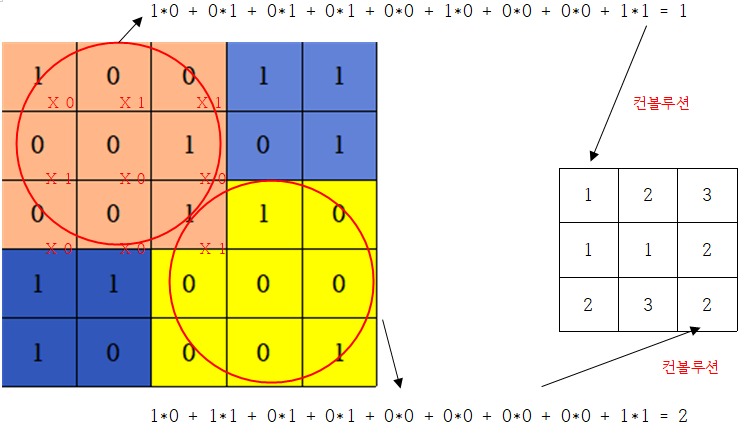

위와 같이 컨볼루션을 수행하면 출력되는 특징 맵의 크기가 입력의 크기보다 작아진다. 컨볼루션을 반복 수행할 경우에는 패딩(padding)으로 이미지 주변에 0을 추가해서 원래의 이미지의 크기로 복원한다.
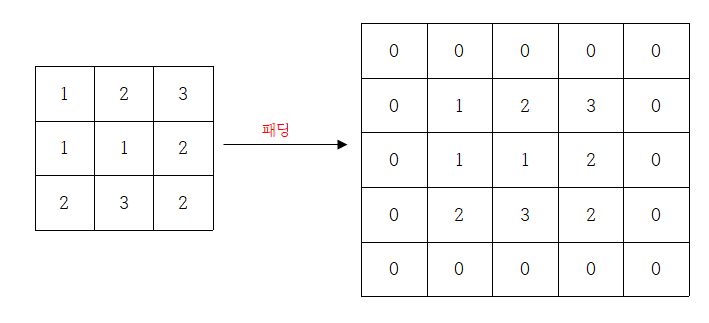

커널 수(필터 수), 커널 사이즈, 스트라이드, 패딩 적용 여부는 컨볼루셔널 레이어를 생성할 때의 파라미터다. 또한, 위 그림에서는 2차원 이미지의 컨볼루션을 예로 들었지만, 실제로는 3차원(RGB)의 이미지를 컨볼루션하는 경우가 많다.

# 풀링 레이어
컨볼루셔널 레이어의 출력인 '특징 맵'을 압축해서 데이터 양을 줄이는 레이어다. 부분 구간의 최댓값을 사용(Max 풀링)하거나, 평균값을 사용(Average 풀링)해 데이터를 압축한다.


In [ ]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, MaxPool2D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# 데이터 세트 준비
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# 데이터 형태 확인

훈련 데이터와 훈련 라벨은 50,000개, 테스트 이미지와 테스트 라벨은 10,000개임을 확인할 수 있다. 이미지 사이즈는 32*32*3이다. RGB 이미지이므로 '*3'이 붙는다.

In [ ]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


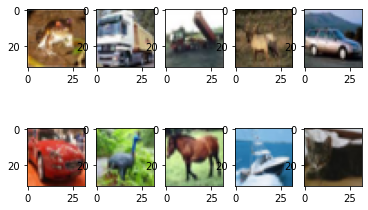

In [ ]:
# 데이터 세트 이미지 확인
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(train_images[i])
plt.show()

In [ ]:
# 데이터 세트 라벨 확인
print(train_labels[0:10])

[[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]


# 데이터 세트 전처리 및 확인
훈련 이미지와 테스트 이미지를 표준화한다.

이미지의 RGB 값이 0-255이므로 255로 나누어 0.0-1.0으로 변환한다.

이미지 배열의 엘리먼트인 이미지는 1차원이 아니라 3차원을 그대로 사용하는 것에 주의한다. 전결합 레이어의 입력은 1차원이지만, 컨볼루셔널 레이어의 입력은 3차원이기 때문이다.

In [ ]:
# 데이터 세트 이미지 전처리
train_images = train_images.astype('float32')/255.0
test_images = test_images.astype(np.float32)/255.0

# 데이터 세트 이미지 전처리 후 형태 확인
print(train_images.shape)
print(test_images.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [ ]:
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

print(train_labels.shape)
print(test_labels.shape)

(50000, 10)
(10000, 10)


# 모델 생성
먼저, '컨볼루셔널 레이어 -> 컨볼루셔널 레이어 -> 풀링 레이어' 형태의 컨볼루셔널 블록(convolution block)을 2개 겹쳐서 사용한다. 이 부분에서 특징을 추출한다.

다음으로, 'Flatten'을 사용해 컨볼루셔널 레이어의 3차원 출력을 전결합 레이어의 입력에 맞춰 1차원으로 변환한다. 마지막으로 전결합 레이어를 2개 겹친다. 이 단계에서 분류를 수행한다.

- Conv2D : 컨볼루셔널 레이어. 인수는 커널 수. 커널 사이즈, 활성화 함수, 패딩
- MaxPool2D : 풀링 레이어(Max 풀링). 인수는 풀링 적용 영역
- Dense : 전결합 레이어. 인수는 유닛 수. 활성화 함수
- Dropout : 드롭아웃. 인수는 무효로 취급할 비율
- Flatten : 레이어의 입출력을 1차원으로 변환

In [ ]:
# 모델 생성
model = Sequential()

# Conv -> Conv -> Pool -> Dropout
model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(32,32,3)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Conv -> Conv -> Pool -> Dropout
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Flatten -> Dense -> Dropout -> Dense
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

손실 함수는 분류이므로 'categorical_crossentropy', 최적화 함수는 'Adam', 평가 지표는 'acc'를 지정한다.

In [ ]:
# 컴파일
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['acc'])

In [ ]:
# 학습
history = model.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split=0.1)

Epoch 1/20
352/352 [==============================] - 187s 529ms/step - loss: 1.8701 - acc: 0.3075 - val_loss: 1.2383 - val_acc: 0.5612
Epoch 2/20
352/352 [==============================] - 185s 526ms/step - loss: 1.2655 - acc: 0.5486 - val_loss: 0.9989 - val_acc: 0.6442
Epoch 3/20
352/352 [==============================] - 186s 527ms/step - loss: 1.0712 - acc: 0.6217 - val_loss: 0.8796 - val_acc: 0.6994
Epoch 4/20
352/352 [==============================] - 185s 526ms/step - loss: 0.9380 - acc: 0.6667 - val_loss: 0.8223 - val_acc: 0.7114
Epoch 5/20
352/352 [==============================] - 185s 525ms/step - loss: 0.8347 - acc: 0.7064 - val_loss: 0.7508 - val_acc: 0.7424
Epoch 6/20
352/352 [==============================] - 185s 526ms/step - loss: 0.7764 - acc: 0.7243 - val_loss: 0.7169 - val_acc: 0.7516
Epoch 7/20
352/352 [==============================] - 185s 527ms/step - loss: 0.7057 - acc: 0.7514 - val_loss: 0.7171 - val_acc: 0.7518
Epoch 8/20
352/352 [============================

In [ ]:
# 모델 저장
model.save('convolution.h5')
# 모델 로드
# model = load_model('convolution.h5')

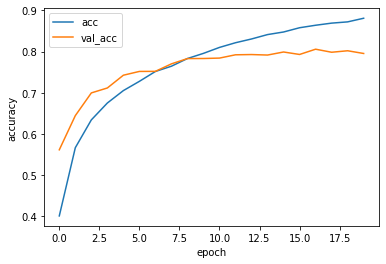

In [ ]:
# 그래프 표시
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

In [ ]:
# 평가
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('loss: {:.3f}\nacc: {:.3f}'.format(test_loss, test_acc))

313/313 [==============================] - 10s 31ms/step - loss: 0.6975 - acc: 0.7834
loss: 0.697
acc: 0.783


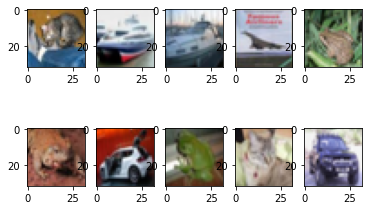

['cat', 'ship', 'ship', 'airplane', 'frog', 'frog', 'automobile', 'deer', 'cat', 'automobile']


In [ ]:
# 추론할 이미지 표시
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(test_images[i])
plt.show()

# 추론할 라벨 표시
test_predictions = model.predict(test_images[0:10])
test_predictions = np.argmax(test_predictions, axis=1)
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print([labels[n] for n in test_predictions])